In [1]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.dataprocessing.transformers.diff import Diff
from darts.utils.statistics import plot_hist
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel, TFTModel, NHiTSModel, RNNModel, TFTModel
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

from utils import *
import wandb
wandb.login()


import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)


def predict_testset(model, ts, ts_covs):

    historics = model.historical_forecasts(ts, 
                                        future_covariates= ts_covs,
                                        start=ts_test_piped.get_index_at_point(n_lags),
                                        verbose=False,
                                        stride=3, 
                                        forecast_horizon=n_ahead, 
                                        retrain=False, 
                                        last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                        )
    ts_predictions = ts_list_concat(historics, eval_stride) # concatenating the batches into a single time series for plot 1, this keeps the n_ahead
    ts_predictions_inverse = pipeline.inverse_transform(ts_predictions) # inverse transform the predictions, we need the original values for the evaluation
    return ts_predictions_inverse.pd_series().to_frame('prediction')






Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


In [2]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')
model_dir = os.path.join(os.getcwd(), 'models')

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
# run parameters

config_dataset = {
    'spatial_scale': '1_county',
    'temp_resolution': 60,
    'location': 'New_York',
}

config_modeldesign = {'boxcox': True,
                    'horizon_in_hours': 24, # in hours
                    'lookback_in_hours': 24, # in hours
                    'liklihood': None,
                    'weather': True,
                    'holiday': True,
                    'datetime_encodings': True,
                    }
                   
config_encoders =  {
                    "cyclic": {"future": ["hour"]}, 
                    "position": {"future": ["relative",]},
                    "datetime_attribute": {"future": ["dayofweek", "week"]},
                    'position': {'past': ['relative'], 'future': ['relative']},
            }



In [4]:
# calculate derived parameters
datetime_encoders = config_encoders if config_modeldesign['datetime_encodings'] else None
timesteps_per_hour = int(60 / config_dataset['temp_resolution'])
n_lags = config_modeldesign['lookback_in_hours'] * timesteps_per_hour
n_ahead = config_modeldesign['horizon_in_hours'] * timesteps_per_hour
list_metrics = [smape, mape, rmse, r2_score, mae] # evaluation metrics
eval_stride = n_ahead # evaluation stride, how often to evaluate the model, in this case we evaluate every n_ahead steps

# Loading Data
df_train = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/train_target')
df_val = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/val_target')
df_test = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/test_target')
df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/train_cov')
df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/val_cov')
df_cov_test = pd.read_hdf(os.path.join(dir_path, f'{config_dataset["spatial_scale"]}.h5'), key=f'{config_dataset["location"]}/{config_dataset["temp_resolution"]}min/test_cov')

In [5]:
# into darts format
ts_train = darts.TimeSeries.from_dataframe(df_train)
ts_val = darts.TimeSeries.from_dataframe(df_val)
ts_test = darts.TimeSeries.from_dataframe(df_test)

# Covariates
ts_cov_train = darts.TimeSeries.from_dataframe(df_cov_train)
ts_cov_val = darts.TimeSeries.from_dataframe(df_cov_val)[:1000]
ts_cov_test = darts.TimeSeries.from_dataframe(df_cov_test)[:1000]

# make sure the indices are the same, TODO: move this to the data_prep.ipynb
ts_train, ts_cov_train = make_index_same(ts_train, ts_cov_train)
ts_val, ts_cov_val = make_index_same(ts_val, ts_cov_val)
ts_test, ts_cov_test = make_index_same(ts_test, ts_cov_test)

In [6]:
# Load pipeline
pipeline = Pipeline(
                    [
                    BoxCox() if config_modeldesign['boxcox'] else None,
                    Scaler(MinMaxScaler()),
                    ]
                     )

ts_train_piped = pipeline.fit_transform(ts_train)
ts_val_piped = pipeline.transform(ts_val)
ts_test_piped = pipeline.transform(ts_test)

# Weather Pipeline
pipeline_weather = Pipeline([Scaler(RobustScaler())])
ts_train_weather_piped = pipeline_weather.fit_transform(ts_cov_train)
ts_val_weather_piped = pipeline_weather.transform(ts_cov_val)
ts_test_weather_piped = pipeline_weather.transform(ts_cov_test)

In [7]:
trg_train_inversed = pipeline.inverse_transform(ts_train_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_val_inversed = pipeline.inverse_transform(ts_val_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_test_inversed = pipeline.inverse_transform(ts_test_piped, partial=True) # inverse transform the target, we need the original values for the evaluation

## Hyperparameter Tuning with wandb sweep

### XGBoost

### LightGBM

### GRU Model

In [8]:
config_sweep = {
    'name': 'GRU sweep' + config_dataset['spatial_scale'] + config_dataset['location'] + str(config_dataset['temp_resolution']),
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'values': [5e-2, 1e-3, 3e-4]
},
        'hidden_dim': {
            'values': [512, 1024, 2048]
},
        'n_rnn_layers': {
            'values': [1, 2, 3]
},
        'dropout': {
            'values': [0.1, 0.2, 0.3]
},
        'batch_size': {
            'values': [32, 64, 128]
},
        'lookback_in_hours': {
            'values': [8, 24, 48, 72]
},
}
}



In [9]:
def train_gru():

    wandb.init()
    config = wandb.config

    optimizer_kwargs = {}

    optimizer_kwargs['lr'] = config.lr
    
    n_lags = config.lookback_in_hours * timesteps_per_hour

    pl_trainer_kwargs = {
        'max_epochs': 1,
        'accelerator': 'gpu',
        'devices': [0],
        'callbacks': [EarlyStopping(monitor='val_loss', patience=10, mode='min')],
        'logger': WandbLogger(log_model=True),
    }

    schedule_kwargs = {
        'patience': 5,
        'factor': 0.5,
        'min_lr': 1e-5,
        'verbose': True
        }

    model = RNNModel(  
                            model = 'GRU',
                            input_chunk_length=n_lags,
                            output_chunk_length=n_ahead,
                            hidden_dim=config.hidden_dim,
                            n_rnn_layers=config.n_rnn_layers,
                            batch_size=config.batch_size,
                            dropout=config.dropout,
                            add_encoders=datetime_encoders,
                            likelihood=None,
                            pl_trainer_kwargs=pl_trainer_kwargs,
                            optimizer_kwargs=optimizer_kwargs,
                            lr_scheduler_cls=ReduceLROnPlateau,
                            lr_scheduler_kwargs=schedule_kwargs,
                            random_state=42,
                            )

    model.fit(ts_train_piped[:300], future_covariates = ts_cov_train[:300], val_series=ts_val_piped, val_future_covariates=ts_cov_val, verbose=True)

    predictions = predict_testset(model, ts_test_piped, ts_cov_test)

    fig = px.line(predictions)
    fig.add_scatter(fig, x=trg_test_inversed.pd_series().index, y=trg_test_inversed.pd_series(), name='target')
    wandb.log({'predictions': fig})

    

    # Evaluate

    # make predictions
    

    wandb.finish()



sweep_id = wandb.sweep(config_sweep, project="WattCast")
wandb.agent(sweep_id, train_gru, count=1)

Create sweep with ID: pbufjhzp
Sweep URL: https://wandb.ai/wattcast/WattCast/sweeps/pbufjhzp


wandb: Agent Starting Run: 6ivqt668 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_dim: 512
wandb: 	lookback_in_hours: 72
wandb: 	lr: 0.05
wandb: 	n_rnn_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 4.0 M 
4 | V             | Linear           | 513   
---------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
31.621    Total estimated model params size (MB)
wandb: WARNING Config item 'hidden_dim' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'hidden_dim' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'hidden_dim' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'hidden_dim' was locked by 'sw

### Transformer Model

In [39]:
test_sets = {"Winter": (ts_val_piped, ts_cov_val, trg_val_inversed), "Summer": (ts_test_piped, ts_cov_test,trg_test_inversed)} # see data_prep.ipynb for the split

In [ ]:

dict_result_season = {}
for season, (ts, ts_cov, gt) in test_sets.items():
    print(f"Testing on {season} data")
    # Generating Historical Forecasts for each model
    ts_predictions_per_model = {}
    historics_per_model = {}
    for model_name, model in models_dict.items():
        print(f"Generating historical forecasts for {model_name}")
        covs_use = None if not config.weather else ts_cov
        historics = model.historical_forecasts(ts, 
                                            future_covariates= covs_use,
                                            start=ts_test_piped.get_index_at_point(n_lags),
                                            verbose=False,
                                            stride=3, 
                                            forecast_horizon=n_ahead, 
                                            retrain=False, 
                                            last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                            )
        
        historics_per_model[model_name] = historics # storing the forecasts in batches of the forecasting horizon, for plot 2
        ts_predictions = ts_list_concat(historics, eval_stride) # concatenating the batches into a single time series for plot 1, this keeps the n_ahead
        ts_predictions_inverse = pipeline.inverse_transform(ts_predictions) # inverse transform the predictions, we need the original values for the evaluation
        ts_predictions_per_model[model_name] = ts_predictions_inverse
    
    
    dict_result_season[season] = historics_per_model, ts_predictions_per_model, gt

## Plots & Analysis

### Plot 1: Side-by-side comparison of the models

In [42]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    fig = px.line(gt.pd_series().to_frame("ground_truth"))
    for model_name in model_names:
        preds = preds_per_model[model_name]
        fig.add_scatter(x=preds.pd_series().index, y=preds.pd_series().values, name="prediction_" + model_name)
    
    fig.update_layout(title=f"{season}")
    fig.update_xaxes(title_text="Time")
    fig.update_yaxes(title_text=f"Power [{ts_train.components[0][-2:]}]")
    fig.show()
    wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth for {config.spatial_scale} in {config.location}": fig})

### Error Metrics Table

In [43]:
dict_table_metrics_per_season = {}

for season, (_, preds_per_model, gt) in dict_result_season.items():
    table = get_error_metric_table(list_metrics, preds_per_model, gt).reset_index()
    wandb.log({f"{season} - Error metrics for {config.spatial_scale} in {config.location}": wandb.Table(dataframe=table)})
    dict_table_metrics_per_season[season] = table


In [47]:
dict_table_metrics_per_season["Winter"]

,index,smape,mape,rmse,r2_score,mae
0,LinearRegressionModel,7.286829,7.295705,1.725638,0.447120,1.337546
1,LightGBMModel,4.280896,4.194684,0.956056,0.818859,0.774559
2,RNNModel,55.021962,41.562276,16.433300,-3.674851,14.512122


### Plot 2: Error Metric Trajectories

Text(0.5, 1.0, 'Normalised RMSE of the Historical Forecasts in New_York')

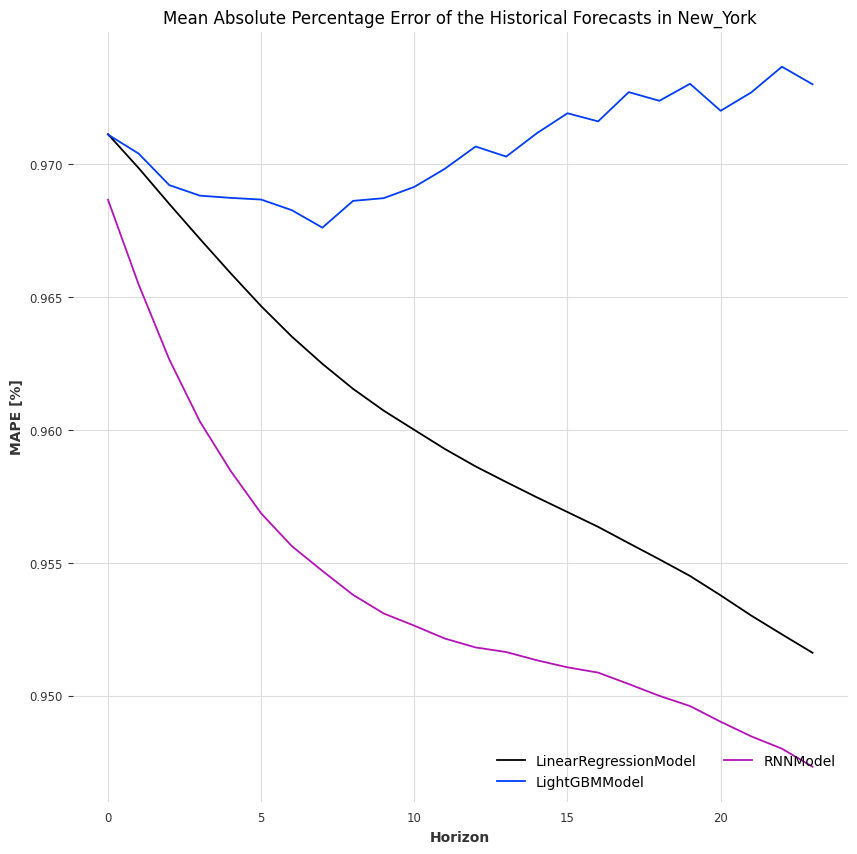

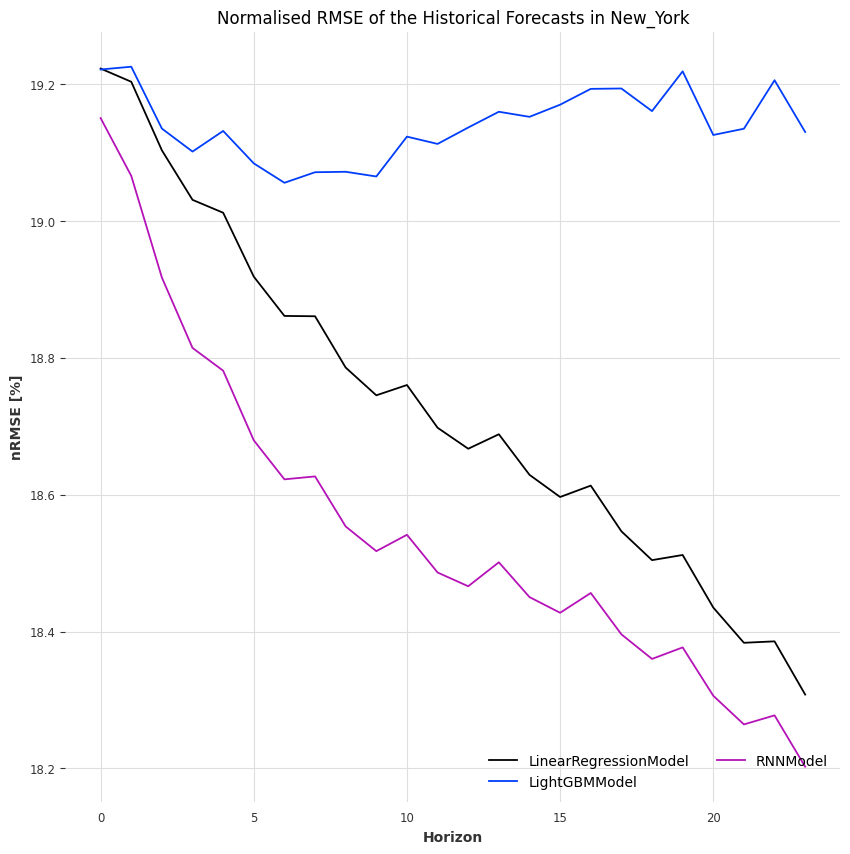

In [48]:
df_smapes_per_model = []
df_nrmse_per_model = []
for model_name, historics in historics_per_model.items():
    df_list = get_df_compares_list(historics, trg_test_inversed)
    means_per_timestep = pd.concat(df_list, axis=1).filter(like = "gt").mean(axis=1).values # mean of the ground truth values on a timestep basis
    diffs = get_df_diffs(df_list)
    df_smapes = abs(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_smapes.columns = [model_name]
    df_nrmse = np.square(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_nrmse.columns = [model_name]

    df_smapes_per_model.append(df_smapes)
    df_nrmse_per_model.append(df_nrmse)

df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1)
df_smapes_per_model.columns = model_names
df_nrmse_per_model = pd.concat(df_nrmse_per_model, axis=1)
df_nrmse_per_model.columns = model_names

df_smapes_per_model.plot(figsize=(10,10))
plt.xlabel('Horizon')
plt.ylabel('MAPE [%]')
plt.legend(loc = 'lower right', ncol = 2)
plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {config.location}")

df_nrmse_per_model.plot(figsize=(10,10))
plt.xlabel('Horizon')
plt.ylabel('nRMSE [%]')
plt.legend(loc = 'lower right', ncol = 2)
plt.title(f"Normalised RMSE of the Historical Forecasts in {config.location}")

### Plot 3: Error distribution

In [ ]:
residuals = 

### Plot 4: Performance on Extreme Events